In [1]:
!pip install pmdarima

Install Libraries

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
     

We read the data using pd.read_csv and writing parse_date=True, makes sure that pandas understands that it is dealing with date values and not string values.

Next we drop any missing values and print the shape of the data. df.head() prints the first 5 rows of the dataset. 

In [3]:
df=pd.read_csv('MaunaLoaDailyTemps.csv',index_col='DATE',parse_dates=True)
df=df.dropna()
print('Shape of data',df.shape)
df.head()

Shape of data (1821, 5)


,MinTemp,MaxTemp,AvgTemp,Sunrise,Sunset
DATE,,,,,
2014-01-01,33.0,46.0,40.0,657,1756
2014-01-02,35.0,50.0,43.0,657,1756
2014-01-03,36.0,45.0,41.0,657,1757
2014-01-04,32.0,41.0,37.0,658,1757
2014-01-05,24.0,38.0,31.0,658,1758


<b>Plot Your data</b>

The next is to plot out your data. This gives you an idea of whether the data is stationary or not. 

Any time series data that has to be modeled needs to be stationary. Stationary means that it’s statistical properties are more or less constant with time. 

These are the following properties that any stationarity model will have:

Constant Mean

Constant Variance(There can be variations, but the variations shouldn’t be irregular)

No seasonality(No repeating patterns in the data set)

So first step is to check for stationarity. If your data set is not stationary, you’ll have to convert it to a stationary series. 

We have a fixed easy test to check for stationarity called the ADF(Augmented Dickey Fuller Test).

Since we am only interested in predicting the average temperature, that is the only column I will be plotting.

<AxesSubplot:xlabel='DATE'>

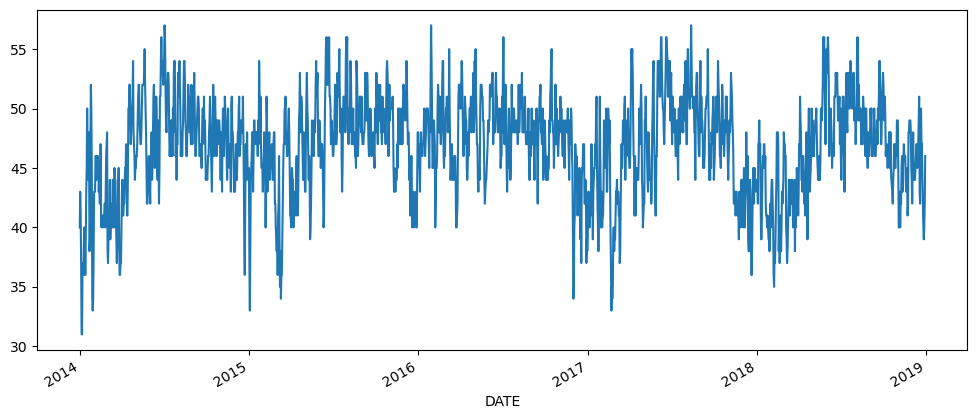

In [4]:
df['AvgTemp'].plot(figsize=(12,5))

<b>Checking For Stationarity</b>

Right off the bat, we can see that it seems to have somewhat of a constant mean around 45. And the fluctuations also seem to be more or less the same. However to be sure if the data is stationary or not, we run a fixed statistical test using the following code:

The adfuller function is called with the dataset and the autolag parameter set to 'AIC', which specifies that the function should choose the optimal number of lags for the test based on the Akaike Information Criterion (AIC). The result of the test is stored in the variable dftest.

In [5]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

This part of the code prints out various statistics and test results obtained from the ADF test:

dftest[0]: The test statistic (ADF statistic).

dftest[1]: The p-value of the test.

dftest[2]: The number of lags used in the regression when the test statistic was calculated. It represents the number of past observations used to predict the current observation.

dftest[3]: The number of observations used in the ADF regression and the calculation of critical values.

dftest[4]: A dictionary containing critical values for the test statistic at different significance levels. The loop iterates over this dictionary and prints out each critical value along with its significance level.

Autoregressive Process: Many time series data exhibit autocorrelation, meaning that the value of the series at one time depends on its previous values. Autoregressive models capture this dependence by regressing the current value of the series on its past values. The number of past values included in this regression is determined by the lag parameter.

Lag Parameter in ADF Test: In the ADF test, the null hypothesis assumes the presence of a unit root in the autoregressive process, indicating non-stationarity. The test statistic is computed based on a regression model where the current value of the series is regressed on its lagged values. The lag parameter (dftest[2] in your code) indicates how many lagged values are included in this regression. It represents the number of past observations used to predict the current observation.

In [6]:
adf_test(df['AvgTemp'])

1. ADF :  -6.554680125068785
2. P-Value :  8.675937480199322e-09
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1808
5. Critical Values :
	 1% :  -3.433972018026501
	 5% :  -2.8631399192826676
	 10% :  -2.5676217442756872


You don’t need to worry about all the complex statistics. To interpret the test results, you only need to look at the p value. And you use the following simple method:

If p< 0.05 ; Data is stationary

if p>0.05; Data is not stationary

It’s not a hard and fast rule, but a stationary data should have a small p value. Larger p value could indicate presence of certain trends(varying mean) or seasonality as well.

## ARIMA MODEL

<b>ARIMA is composed of 3 terms(Auto-Regression + Integrated+Moving-Average)</b>

1. Auto-Regression:

This basically means that you are using the previous values of the time series in order to predict the future. How many past values you use, determine the order of the AR model. Here’s how an AR(1) model looks like:


<b>Y(t)= Some_Constant*Y(t-1)+ Another_Constant +Error(t)</b>

2. Integrated:

So, remember our talk on stationarity, and how it’s extremely important? Well if you are data set is not stationary, you most often need to perform some sort of difference operation to make it stationary. If you are differencing with previous value, its order 1 and so on. Here’s an example of that:

But as you can the series Y(t) was not stationary, because of an increasing trend resulting in a varying mean. We simply subtract it from previous values and voila! It becomes stationary. Depending on your data, you might have to repeat the differencing to get a second order differencing , third order and so on..

3. Moving Average:

This basically means that you are using previous errors to make the future prediction. Also makes sense, right? By seeing how wrong you were in your prediction, you take that into account to make a better prediction. And just like in an AR model, the number of previous errors(also called number of lags) you use, determines the order of the model.

Here’s how MA(1) order equation looks like:
Y(t)= Mean + Some_Constant*Error(t-1) +Error(t)

So our main job is to decide the order of the AR, I, MA parts which are donated by(p,d,q) respectively.

In [7]:
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

We simple supply our data to the auto_arima function. The function basically uses something called as the AIC score to judge how good a particular order model is. It simply tries to minimize the AIC score

In [8]:
stepwise_fit = auto_arima(df['AvgTemp'], 
                          suppress_warnings=True)           

stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1821
Model:               SARIMAX(1, 0, 5)   Log Likelihood               -4139.134
Date:                Thu, 07 Mar 2024   AIC                           8294.268
Time:                        23:47:31   BIC                           8338.325
Sample:                             0   HQIC                          8310.522
                               - 1821                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1617      0.352      3.296      0.001       0.471       1.852
ar.L1          0.9751      0.008    128.504      0.000       0.960       0.990
ma.L1         -0.1285      0.024     -5.448      0.000      -0.175      -0.082
ma.L2         -0.2208      0.024     -9.194      0.000      -0.268      -0.174
ma.L3         -0.2032      0.024     -8.523      0.000      -0.250      -0.156
ma.L4         -0.1377      0.023     -6.055      0.000      -0.182      -0.093
ma.L5         -0.0510      0.024     -2.092      0.036      -0.099      -0.003
sigma2         5.4988      0.172     31.947      0.000       5.161       5.836
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                19.95
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.17
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We can see the best ARIMA model seems to be of the order (1,0,5) with the minimum AIC score=8294.785. With this knowledge we can finally proceed to train and fit the model to start making prediction!

This statement indicates the identification of the best-fitting ARIMA (AutoRegressive Integrated Moving Average) model for a given time series dataset based on the Akaike Information Criterion (AIC). Here's a breakdown of its components:

ARIMA Model: ARIMA is a popular time series forecasting model that combines autoregressive (AR), differencing (I), and moving average (MA) components. The notation (p, d, q) represents the orders of the AR, I, and MA components respectively.

p (AR order): The number of lag observations included in the model. It indicates the number of past observations to consider for predicting the current value.
d (Differencing order): The number of times differencing is applied to make the time series stationary. It helps in removing trends and seasonality.
q (MA order): The size of the moving average window. It represents the number of lagged forecast errors in the prediction equation.
Best ARIMA Model: The statement indicates that after exploring different ARIMA models with various combinations of p, d, and q parameters, the model with orders (1, 0, 5) was found to have the lowest AIC score.

AIC Score: AIC (Akaike Information Criterion) is a measure of the relative quality of a statistical model for a given dataset. It balances the goodness of fit of the model with the complexity of the model. Lower AIC scores indicate better models. In this case, the model with the order (1, 0, 5) has an AIC score of 8294.785, which is considered the best among the models evaluated.

Training and Fitting the Model: With the identification of the best-fitting ARIMA model, the next step would involve training the model using historical data and fitting it to the dataset. Once the model is trained and fitted, it can be used to make predictions for future time points based on the learned patterns and relationships in the data.

In [9]:
from statsmodels.tsa.arima_model import ARIMA

<b>Split Data into Training and Testing</b>

Before we actually train the model, we have to split the data set into a training and testing section. We do this because we first train the model on the data and keep the testing section hidden from the model. Once model is ready, we ask it to make predictions on the test data and see how well it performs.

In [10]:
print(df.shape)
train=df.iloc[:-30]
test=df.iloc[-30:]
print(train.shape,test.shape)
print(test.iloc[0],test.iloc[-1])

(1821, 5)
(1791, 5) (30, 5)
MinTemp      36.0
MaxTemp      52.0
AvgTemp      44.0
Sunrise     640.0
Sunset     1743.0
Name: 2018-12-01 00:00:00, dtype: float64 MinTemp      39.0
MaxTemp      52.0
AvgTemp      46.0
Sunrise     656.0
Sunset     1754.0
Name: 2018-12-30 00:00:00, dtype: float64


So as you can probably tell, we reserving the last 30 days of the data as the testing section. You can see the shapes of the actual data, and the testing and training sections in the output.

In [11]:
from statsmodels.tsa.arima.model import ARIMA

# Define and fit the ARIMA model
model = ARIMA(train['AvgTemp'], order=(1, 0, 5))
model = model.fit()

# Print the summary of the fitted model
print(model.summary())


                               SARIMAX Results                                
Dep. Variable:                AvgTemp   No. Observations:                 1791
Model:                 ARIMA(1, 0, 5)   Log Likelihood               -4070.198
Date:                Thu, 07 Mar 2024   AIC                           8156.395
Time:                        23:47:33   BIC                           8200.320
Sample:                             0   HQIC                          8172.614
                               - 1791                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.5856      0.758     61.454      0.000      45.100      48.071
ar.L1          0.9856      0.005    188.230      0.000       0.975       0.996
ma.L1         -0.1412      0.023     -6.124      0.0

<AxesSubplot:xlabel='DATE'>

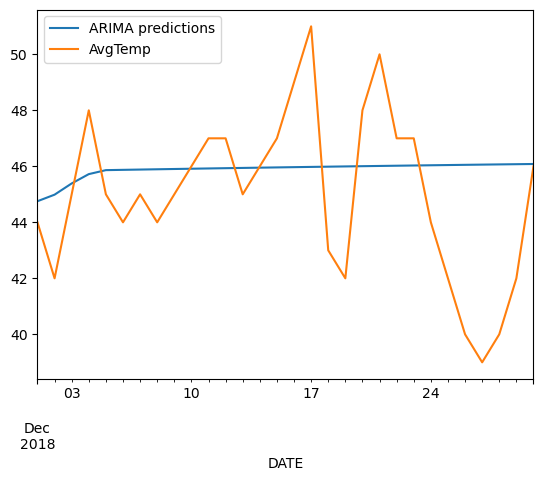

In [12]:
start=len(train)
end=len(train)+len(test)-1
#if the predicted values dont have date values as index, you will have to uncomment the following two commented lines to plot a graph
index_future_dates=pd.date_range(start='2018-12-01',end='2018-12-30')
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')
pred.index=index_future_dates
pred.plot(legend=True)
test['AvgTemp'].plot(legend=True)


<AxesSubplot:xlabel='DATE'>

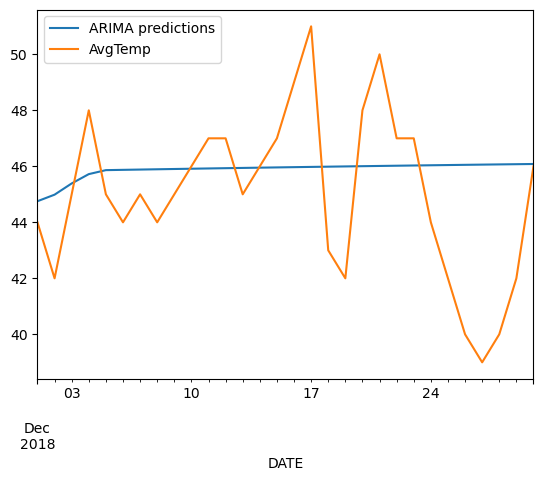

In [13]:
pred.plot(legend='ARIMA Predictions')
test['AvgTemp'].plot(legend=True)

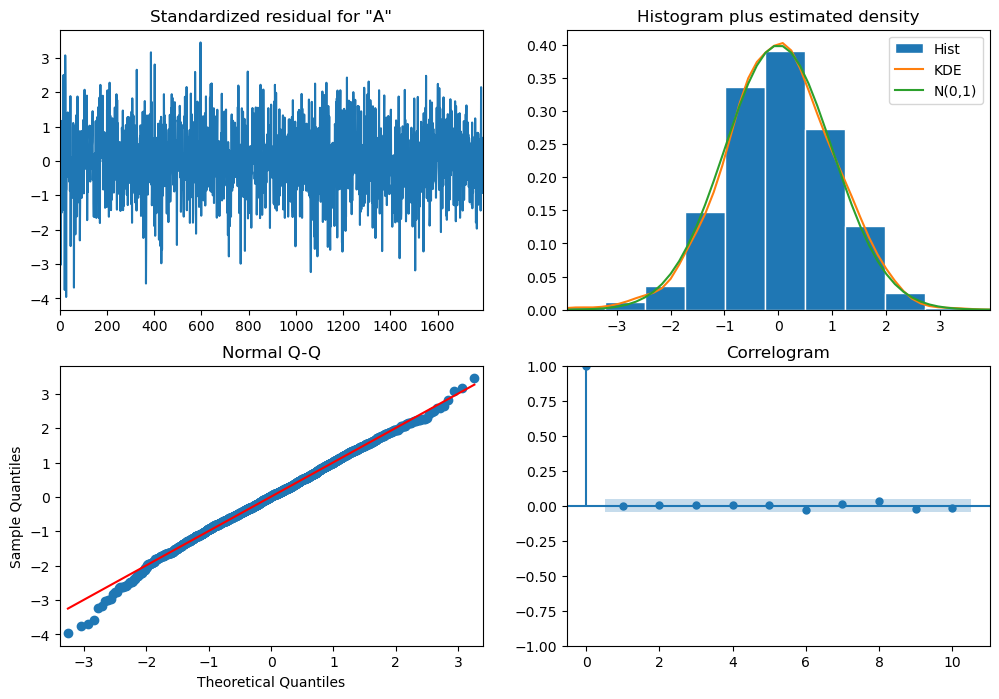

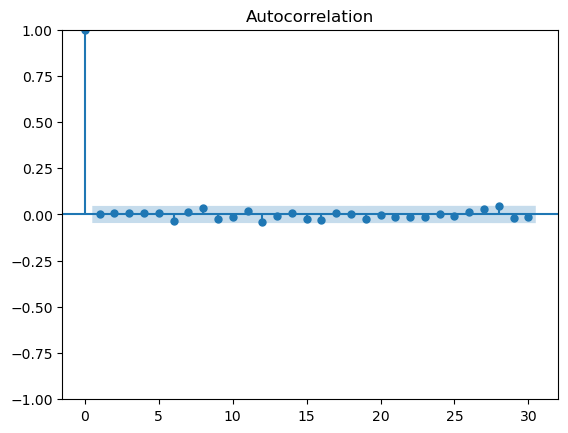

In [14]:
# Check model diagnostics
import statsmodels.api as sm
model.plot_diagnostics(figsize=(12, 8))
plt.show()

# Check residuals autocorrelation
residuals = model.resid
sm.graphics.tsa.plot_acf(residuals, lags=30)
plt.show()

In [15]:
test['AvgTemp'].mean()

45.0

In [16]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred,test['AvgTemp']))
print(rmse)


3.0004640041287756


In [17]:
model2=ARIMA(df['AvgTemp'],order=(1,0,5))
model2=model2.fit()
df.tail()

,MinTemp,MaxTemp,AvgTemp,Sunrise,Sunset
DATE,,,,,
2018-12-26,35.0,45.0,40.0,654,1752
2018-12-27,33.0,44.0,39.0,655,1752
2018-12-28,33.0,47.0,40.0,655,1753
2018-12-29,36.0,47.0,42.0,655,1753
2018-12-30,39.0,52.0,46.0,656,1754


In [18]:
index_future_dates=pd.date_range(start='2018-12-30',end='2019-01-29')
#print(index_future_dates)
pred=model2.predict(start=len(df),end=len(df)+30,typ='levels').rename('ARIMA Predictions')
#print(comp_pred)
pred.index=index_future_dates
print(pred)

2018-12-30    46.418166
2018-12-31    46.113912
2019-01-01    45.617874
2019-01-02    45.249566
2019-01-03    45.116915
2019-01-04    45.136666
2019-01-05    45.156140
2019-01-06    45.175341
2019-01-07    45.194274
2019-01-08    45.212942
2019-01-09    45.231349
2019-01-10    45.249498
2019-01-11    45.267393
2019-01-12    45.285038
2019-01-13    45.302436
2019-01-14    45.319590
2019-01-15    45.336505
2019-01-16    45.353183
2019-01-17    45.369627
2019-01-18    45.385842
2019-01-19    45.401829
2019-01-20    45.417593
2019-01-21    45.433136
2019-01-22    45.448462
2019-01-23    45.463573
2019-01-24    45.478473
2019-01-25    45.493164
2019-01-26    45.507650
2019-01-27    45.521933
2019-01-28    45.536017
2019-01-29    45.549903
Freq: D, Name: ARIMA Predictions, dtype: float64


<AxesSubplot:>

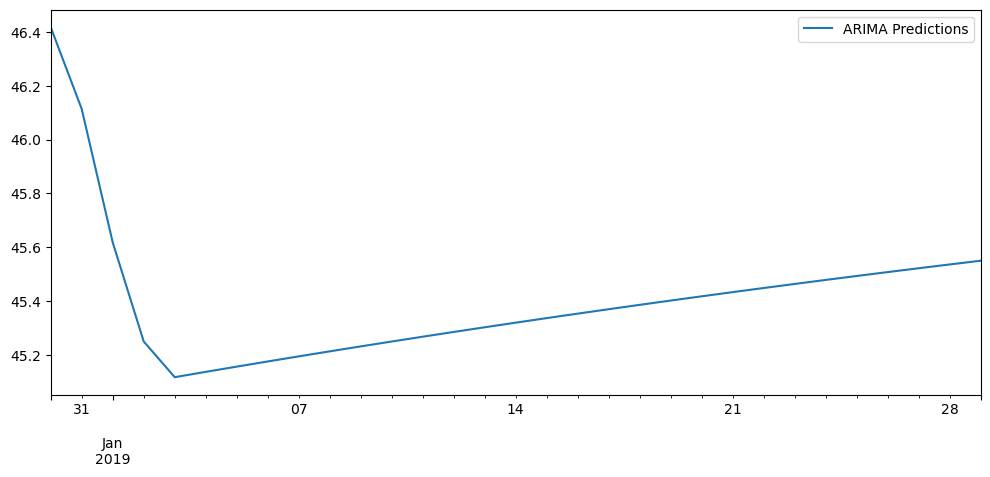

In [19]:
pred.plot(figsize=(12,5),legend=True)